In [1]:
import os
from glob import glob
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf

In [2]:
!nvidia-smi

Mon May 17 15:04:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 5000     On   | 00000000:01:00.0 Off |                  Off |
| 33%   30C    P8    16W / 230W |      1MiB / 16125MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 5000     On   | 00000000:24:00.0 Off |                  Off |
| 33%   

In [3]:
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.compat.v1.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    IMG_HEIGHT = 128
    IMG_WIDTH = 256
    target_size = (IMG_WIDTH, IMG_HEIGHT)
    resized_image = original_im.convert('RGB').resize((IMG_WIDTH, IMG_HEIGHT),Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map

In [4]:
def create_pascal_label_colormap():
  """Creates a label colormap used in cityscapes segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap

In [5]:
def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


In [6]:
def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'road','sidewalk', 'building', 'wall', 'fence', 
    'pole', 'traffic light', 'traffic sign','vegetation', 
    'terrain', 'sky', 'person', 'car', 'truck', 
    'bus', 'train', 'motorcycle', 'bicycle','unlabel'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [7]:
MODEL_NAME = 'xception71_dpc_cityscapes_trainval'

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_cityscapes_trainfine':
        'deeplabv3_mnv2_cityscapes_train_2018_02_05.tar.gz',
    'mobilenetv3_large_cityscapes_trainfine':
        'deeplab_mnv3_large_cityscapes_trainfine_2019_11_15.tar.gz',
    'mobilenetv3_small_cityscapes_trainfine':
        'deeplab_mnv3_small_cityscapes_trainfine_2019_11_15.tar.gz',
    'xception65_cityscapes_trainfine':
        'deeplabv3_cityscapes_train_2018_02_06.tar.gz',
    'xception71_dpc_cityscapes_trainfine':
        'deeplab_cityscapes_xception71_trainfine_2018_09_08.tar.gz',
    'xception71_dpc_cityscapes_trainval':
        'deeplab_cityscapes_xception71_trainvalfine_2018_09_08.tar.gz'   
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.io.gfile.makedirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


In [9]:
# you can change this path to reflect your own settings if necessary
dataset_path = r'./dataset1/'
video_data = r'train_extra/'
sequence_data=r'augsburg/'
fdir=dataset_path+video_data+sequence_data

In [ ]:
files = os.listdir(fdir)
for nm in files:
    if not nm.endswith('.png'):
        continue
    fpth=os.path.join(fdir,nm)
    original_im = Image.open(fpth)
    resized_im, seg_map = MODEL.run(original_im)
    fname=os.path.splitext(nm)
    fnm=fname[0]+"_label.png"
    outdir = os.path.join(fdir, 'label')
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    outpth=os.path.join(outdir, fnm)
    seg_im=Image.fromarray(np.uint8(seg_map))
    seg_im.save(outpth)

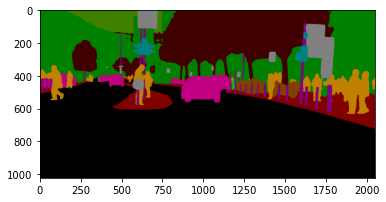

In [153]:
seg_image = label_to_color_image(seg_map).astype(np.uint8)
plt.imshow(seg_image)
im=Image.fromarray(seg_image)
im.save("12.png")

In [ ]:
vis_segmentation(resized_im, seg_map)

In [ ]:
Image.blend(resized_im,seg_image,0.7)